# Klasyfikacja chorób na zbiorze ChestMnist

## Przygotowanie środowiska

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from medmnist import ChestMNIST
from torchvision import transforms
from tqdm import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## Przygotowanie danych

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
train_ds = ChestMNIST(root='./data', split='train', size=224, transform=transform, download=True)
validation_ds = ChestMNIST(root='./data', split='val', size=224, transform=transform, download=True)
test_ds = ChestMNIST(root='./data', split='test', size=224, transform=transform, download=True)

In [7]:
CLASS_NAMES = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

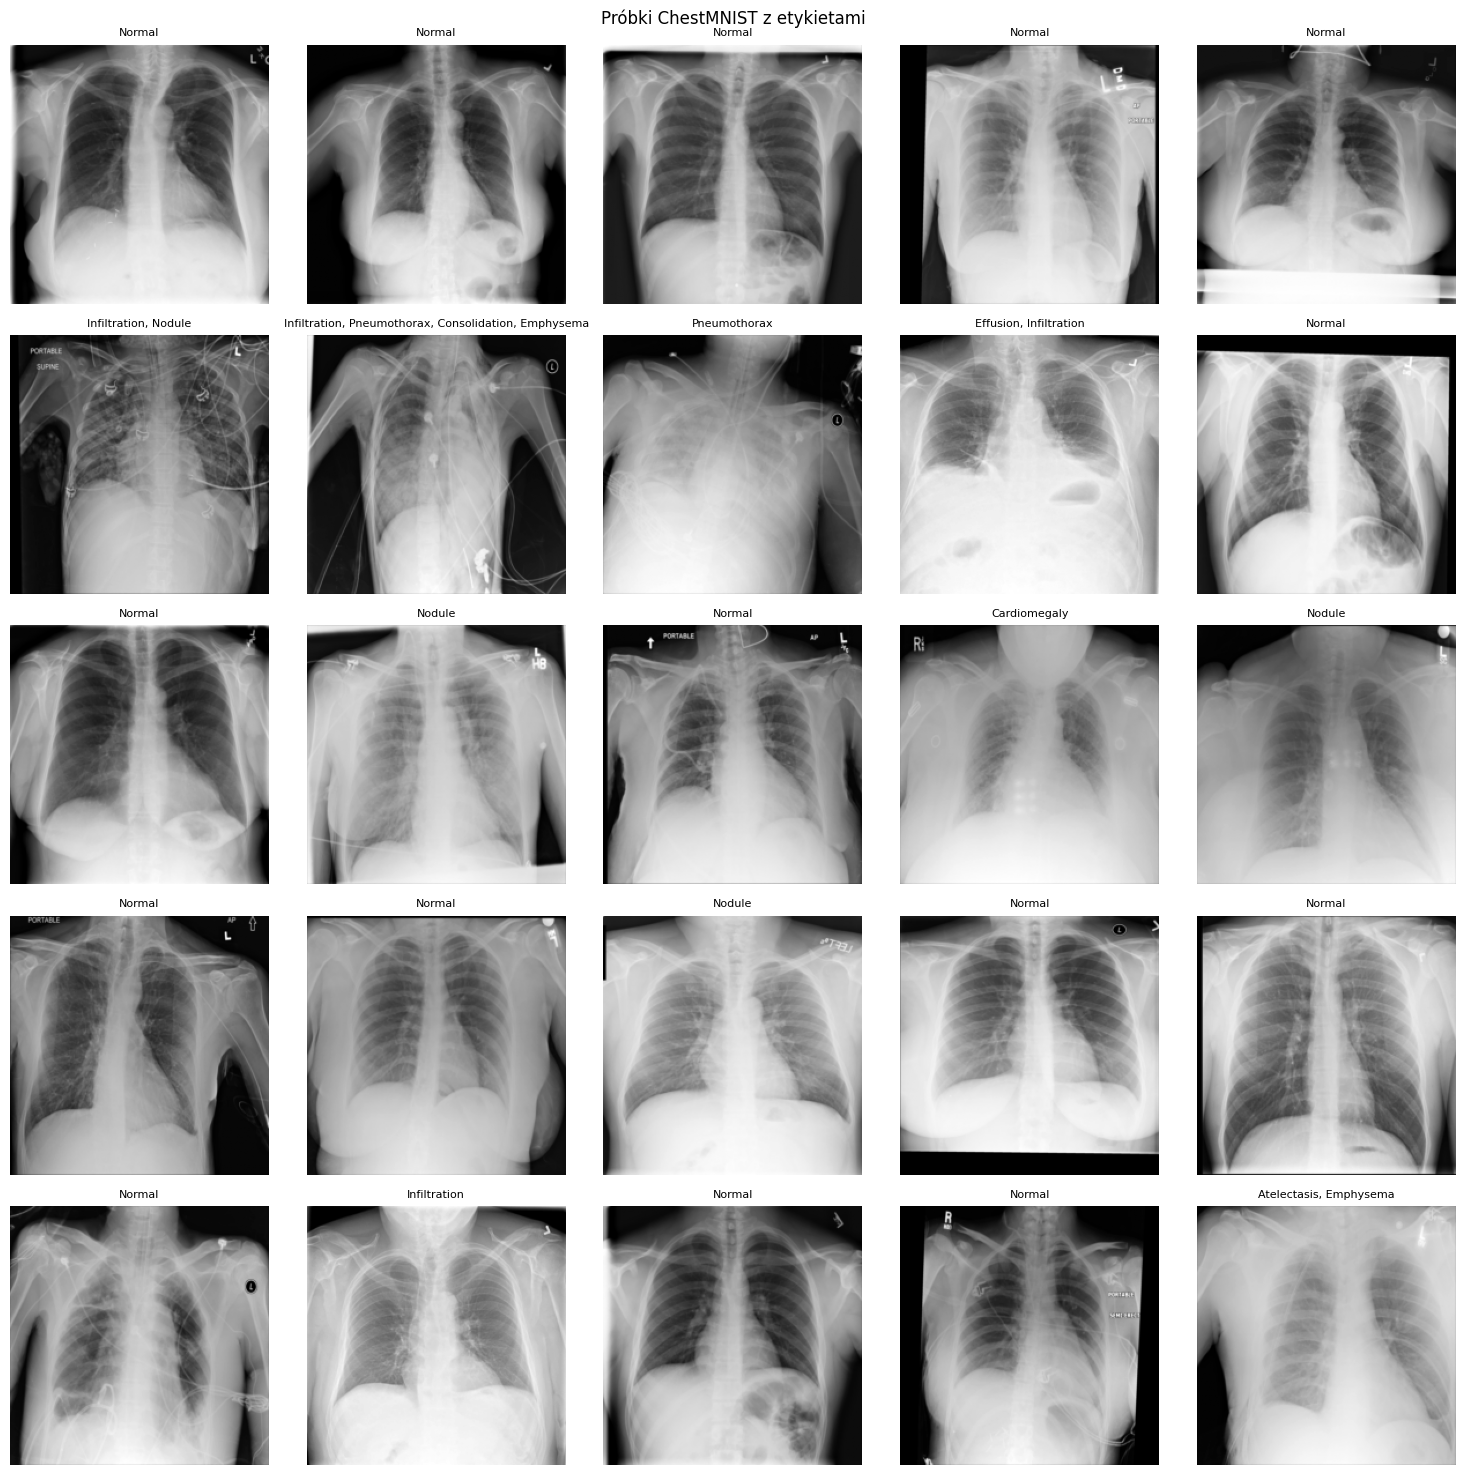

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    img, label = train_ds[i]

    if img.ndim == 3:
        img = img.squeeze(0)

    active_classes = [
        CLASS_NAMES[j] for j, v in enumerate(label) if v == 1
    ]

    title = ", ".join(active_classes) if active_classes else "Normal"

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(title, fontsize=8)
    axes[i].axis("off")

plt.suptitle("Próbki ChestMNIST z etykietami", fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    validation_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## Trenowanie modelu

### Model konwolucyjnej sieci neuronowej

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):    
        super().__init__()
        
        padding = kernel_size // 2

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

    def forward(self, x):
        return self.block(x)

In [11]:
class CNN(nn.Module):                                             
    def __init__(self, in_channels=1, num_labels=14):
        super().__init__()

        self.features = nn.Sequential(
            ConvBlock(in_channels, 32, kernel_size=7),   
            ConvBlock(32, 64, kernel_size=5),             
            ConvBlock(64, 128, kernel_size=5),            
            ConvBlock(128, 256, kernel_size=3),           
            ConvBlock(256, 512, kernel_size=3),           
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_labels)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [14]:
def train_step(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)         

        optimizer.zero_grad()
        outputs = model(inputs)                     
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    epoch_loss = sum(total_loss) / len(total_loss)

    return epoch_loss

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score 

def get_auc(labels, preds):
    auc = 0
    for i in range(labels.shape[1]):
        auc += roc_auc_score(labels[:, i], preds[:, i])
    
    return auc / preds.shape[1]

def get_acc(labels, preds, threshold=0.5):
    acc = 0.0 

    one_zero_preds = (preds > threshold).astype(int)
    for label in range(preds.shape[1]):
        acc += accuracy_score(labels[:, label], one_zero_preds[:, label])

    return acc / preds.shape[1]

In [23]:
import numpy as np

@torch.no_grad()
def validate(model, dataloader, criterion, device, is_eval=False):
    model.eval()
    total_loss = []
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        outputs = model(inputs.to(device))

        loss = criterion(outputs, labels)

        preds = torch.sigmoid(outputs)

        total_loss.append(loss.item())
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    val_loss = np.mean(total_loss)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    auc = get_auc(all_labels, all_preds)
    acc = get_acc(all_labels, all_preds)

    return val_loss, auc, acc, all_preds

In [25]:
model = CNN().to(device)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
N_EPOCHS = 8

train_losses = []
val_losses = []
val_accs = []
val_aucs = []

for epoch in range(N_EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, device)
    val_loss, val_auc, val_acc, _  = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)

    print(
        f"Epoch [{epoch+1}/{N_EPOCHS}], " 
        f"train loss: {train_loss:.4f}, "
        f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val auc: {val_auc:.4f}"
    )

Epoch [1/8], train loss: 0.1763, val loss: 0.1697, val acc: 0.9492, val auc: 0.6992
Epoch [2/8], train loss: 0.1691, val loss: 0.1696, val acc: 0.9492, val auc: 0.7480
Epoch [3/8], train loss: 0.1644, val loss: 0.1614, val acc: 0.9495, val auc: 0.7580
Epoch [4/8], train loss: 0.1611, val loss: 0.1597, val acc: 0.9495, val auc: 0.7754
Epoch [5/8], train loss: 0.1581, val loss: 0.1592, val acc: 0.9492, val auc: 0.7816
Epoch [6/8], train loss: 0.1551, val loss: 0.1632, val acc: 0.9490, val auc: 0.7842
Epoch [7/8], train loss: 0.1523, val loss: 0.1650, val acc: 0.9472, val auc: 0.7839
Epoch [8/8], train loss: 0.1492, val loss: 0.1618, val acc: 0.9482, val auc: 0.7851


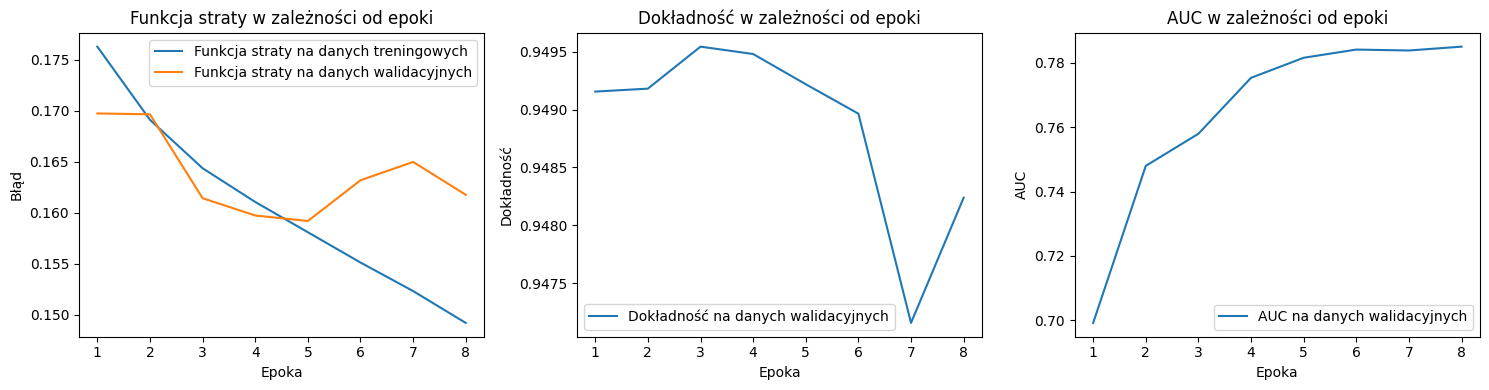

In [28]:
epochs = range(1, N_EPOCHS + 1)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Funkcja straty na danych treningowych")
plt.plot(epochs, val_losses, label="Funkcja straty na danych walidacyjnych")
plt.xlabel("Epoka")
plt.ylabel("Błąd")
plt.title("Funkcja straty w zależności od epoki")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, label="Dokładność na danych walidacyjnych")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.title("Dokładność w zależności od epoki")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_aucs, label="AUC na danych walidacyjnych")
plt.xlabel("Epoka")
plt.ylabel("AUC")
plt.title("AUC w zależności od epoki")
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
torch.save(model.state_dict(), "models/first_model.pt")

In [22]:
model = CNN()
model_state = torch.load("models/first_model.pt", map_location=device)

model.load_state_dict(model_state)

<All keys matched successfully>

In [30]:
_, auc, acc, y_preds = validate(model, test_loader, criterion, device)

print(f"Test AUC: {auc:6f}")
print(f"Test ACC: {acc:6f}")

Test AUC: 0.791111
Test ACC: 0.946807


In [45]:
y_true = test_ds.labels
y_score = y_preds > 0.5

In [48]:
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_score, average='samples', zero_division=1)

print(f"Precision: {precision:6f}")
print(f"Recall: {recall:6f}")
print(f"F1: {f1:6f}")

Precision: 0.926084
Recall: 0.578207
F1: 0.547128


In [47]:
for i in range(y_score.shape[1]):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true[:, i], y_score[:, i], average='micro', zero_division=1)
    print(f"Label {i}: Precision: {precision:.5f}\tRecall: {recall:.5f}\tF1: {f1:.5f}")

Label 0: Precision: 0.89244	Recall: 0.89244	F1: 0.89244
Label 1: Precision: 0.96086	Recall: 0.96086	F1: 0.96086
Label 2: Precision: 0.88575	Recall: 0.88575	F1: 0.88575
Label 3: Precision: 0.82120	Recall: 0.82120	F1: 0.82120
Label 4: Precision: 0.94954	Recall: 0.94954	F1: 0.94954
Label 5: Precision: 0.94036	Recall: 0.94036	F1: 0.94036
Label 6: Precision: 0.98921	Recall: 0.98921	F1: 0.98921
Label 7: Precision: 0.95132	Recall: 0.95132	F1: 0.95132
Label 8: Precision: 0.95734	Recall: 0.95734	F1: 0.95734
Label 9: Precision: 0.98083	Recall: 0.98083	F1: 0.98083
Label 10: Precision: 0.97722	Recall: 0.97722	F1: 0.97722
Label 11: Precision: 0.98386	Recall: 0.98386	F1: 0.98386
Label 12: Precision: 0.96724	Recall: 0.96724	F1: 0.96724
Label 13: Precision: 0.99813	Recall: 0.99813	F1: 0.99813


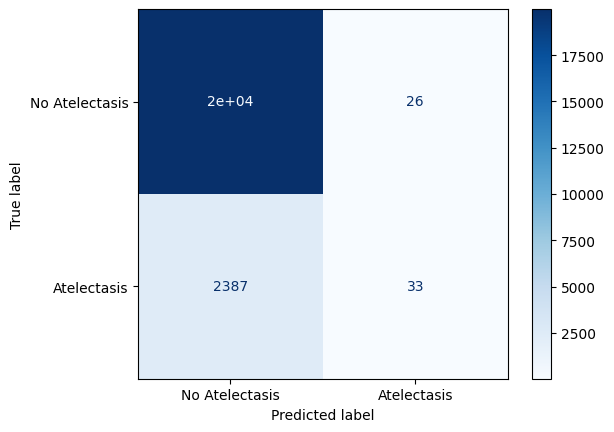

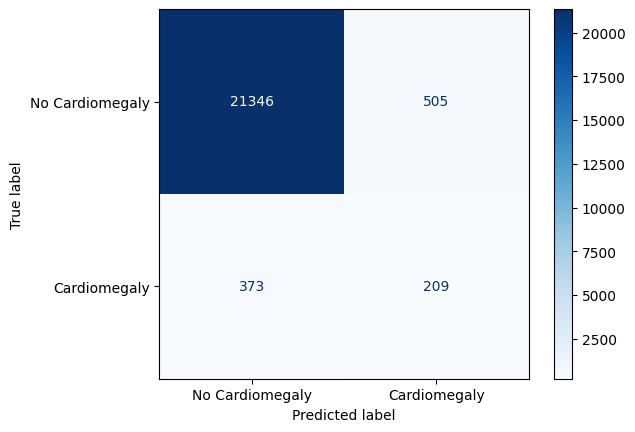

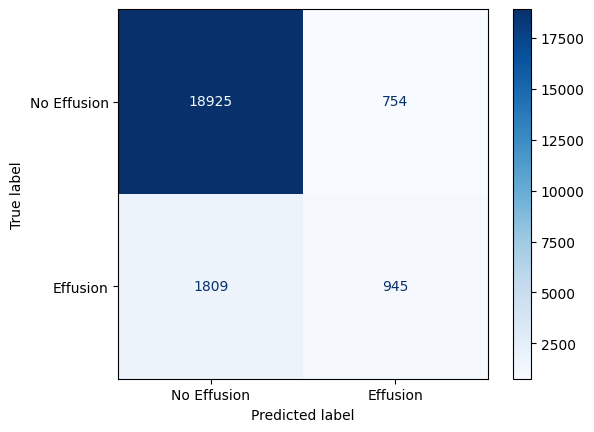

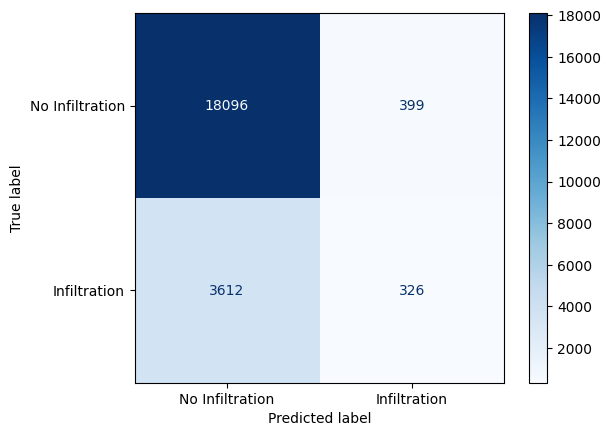

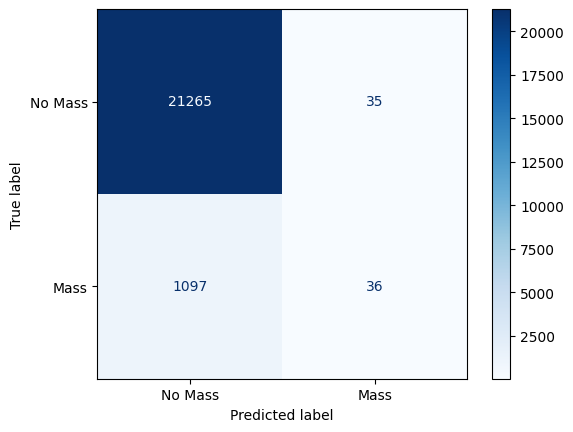

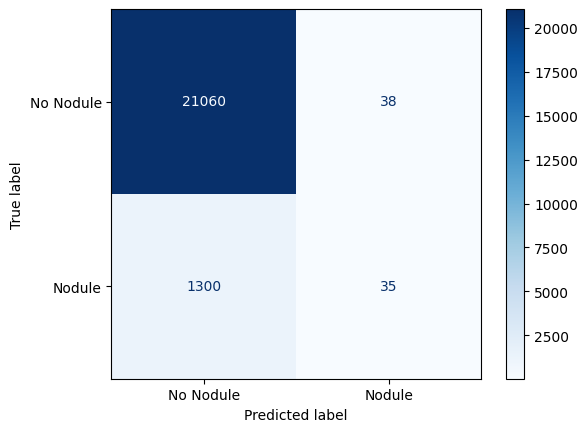

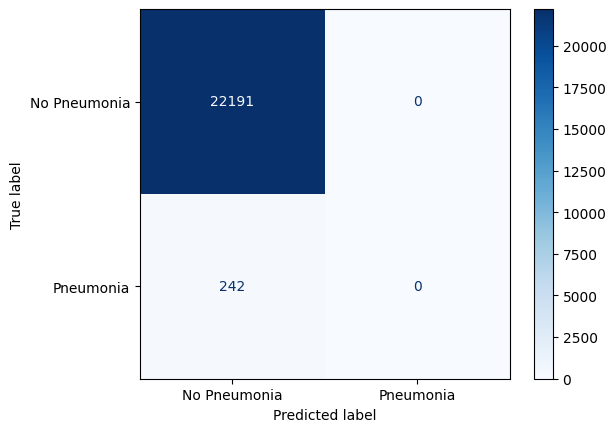

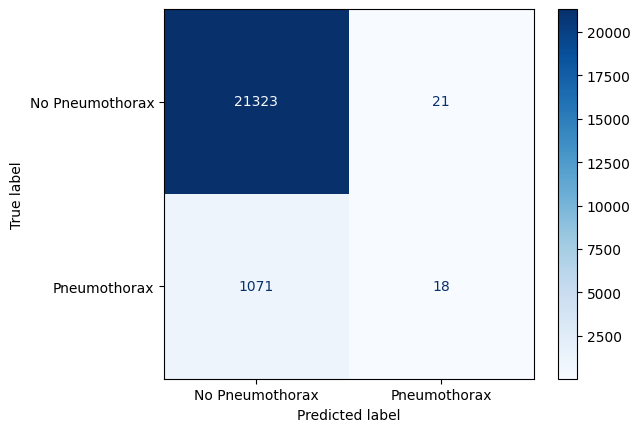

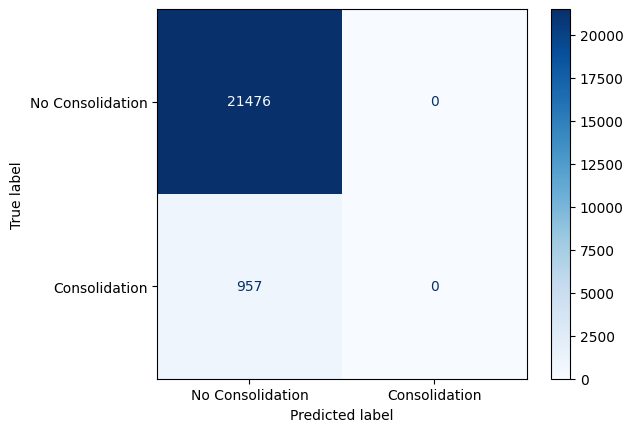

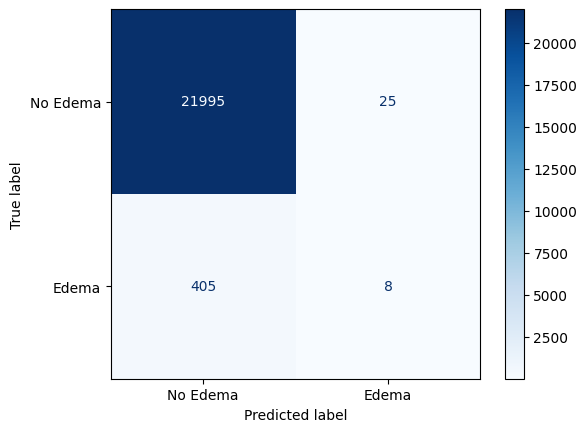

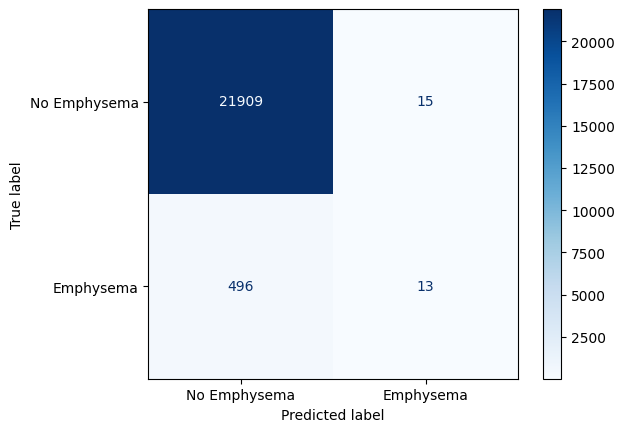

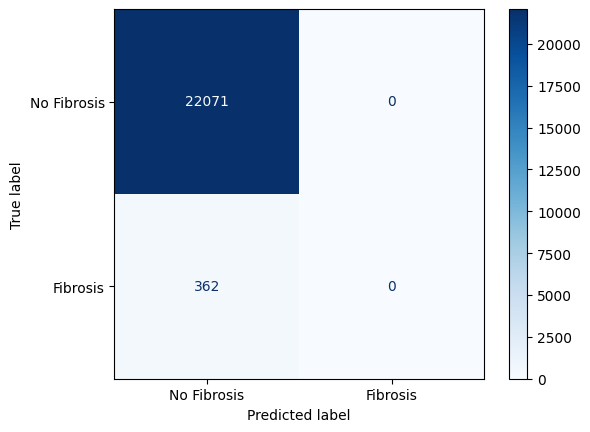

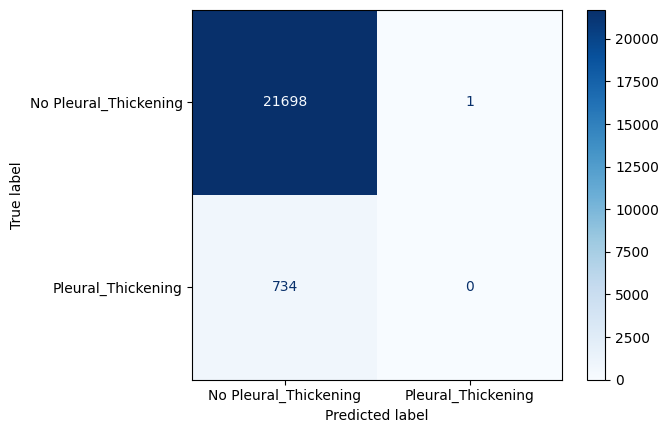

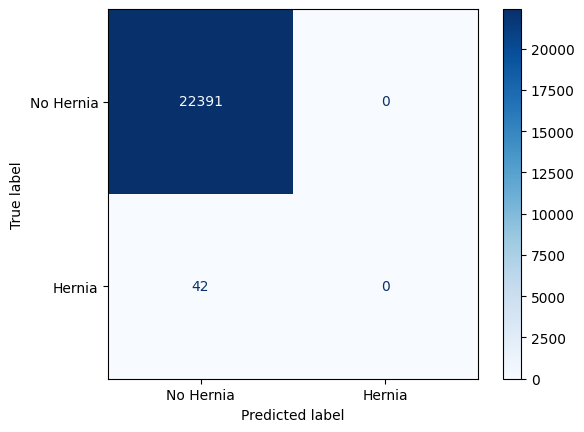

In [53]:
for i in range(y_score.shape[1]):
    ConfusionMatrixDisplay.from_predictions(
        y_true[:, i], 
        y_score[:, i], 
        display_labels=["No " + CLASS_NAMES[i], CLASS_NAMES[i]], 
        cmap='Blues'
    )

## Optymalizacja z Optuna

### Definicja klasy bloku konwolucji

In [15]:
def get_dataloarders(batch_size):
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        validation_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader

In [20]:
import optuna

N_BLOCKS = 5
CHANNELS = [16, 32]
GROWTH_FACTOR = 2
BATCH_SIZES = [16, 32, 64]

class DynamicCNN(nn.Module):
    def __init__(self, in_channels, num_classes, trial):
        super().__init__()

        base_channels = trial.suggest_categorical("base_channels", CHANNELS)

        layers = []
        in_ch = in_channels

        for i in range(N_BLOCKS):
            out_ch = base_channels * (GROWTH_FACTOR ** i)

            if i == 0:
                KERNEL_SIZES = [3, 5, 7]
            elif i <= 2:
                KERNEL_SIZES = [3, 5]
            else:
                KERNEL_SIZES = [3]

            kernel_size = trial.suggest_categorical(f"kernel_size_block_{i}", KERNEL_SIZES)

            layers.append(ConvBlock(in_ch, out_ch, kernel_size))
            in_ch = out_ch

        self.features = nn.Sequential(*layers)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.clf = nn.Linear(in_ch, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.clf(x)

In [21]:
def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", BATCH_SIZES)

    train_loader, val_loader = get_dataloarders(batch_size)

    model = DynamicCNN(
        in_channels=1, 
        num_classes=14, 
        trial=trial
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_auc = 0.0
    epochs = 10

    for epoch in range(epochs):
        _ = train_step(model, train_loader, optimizer, criterion, device)
        _, val_auc, _  = validate(model, val_loader, criterion, device)

        trial.report(val_auc, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        best_auc = max(best_auc, val_auc)

    return best_auc
        

In [24]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)

study.optimize(objective, n_trials=50)

print("Best AUC:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

[I 2026-01-17 11:16:39,989] A new study created in memory with name: no-name-bdadc25d-4a5f-45ff-86d4-afd0355e53f7
[W 2026-01-17 11:21:56,995] Trial 0 failed with parameters: {'lr': 0.0005618149136188763, 'batch_size': 16, 'base_channels': 32, 'kernel_size_block_0': 3, 'kernel_size_block_1': 5, 'kernel_size_block_2': 3, 'kernel_size_block_3': 3, 'kernel_size_block_4': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/szymon/studia/umwdm/umwdm/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1415/1614945136.py", line 22, in objective
    _ = train_step(model, train_loader, optimizer, criterion, device)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1415/3627657442.py", line 16, in train_step
    total_loss.append(loss.item())
                      ^^^^^^^^^^^
Ke

KeyboardInterrupt: 